In [ ]:
# # Для работы в колабе раскоменьте эти строки
# !git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
# %cd DeepGenerativeModels/

# Этап 1. Загрузка данных
В данном задании вам предстоит работать с уже знакомым датасетом с лицами и генерировать новые лица с заданными аттрибутами

In [3]:
# !pip install munch
# !git clone https://github.com/S-aiueo32/lpips-pytorch.git
# !mv lpips-pytorch/lpips_pytorch .

In [ ]:
# !mkdir -p data/celeba
# !wget https://raw.githubusercontent.com/taki0112/StarGAN-Tensorflow/master/dataset/celebA/list_attr_celeba.txt -O data/celeba/tmp.txt
# tail -n +2 data/celeba/tmp.txt > data/celeba/list_attr_celeba.txt

In [45]:
import torch
import torch.nn.functional as F
import torch.utils.data
from lpips_pytorch import LPIPS
from torchvision import transforms
from munch import Munch
import gc
from tqdm.auto import trange

from celeba import CelebADataset


## Setup
# Number of gpus available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

args = Munch()

# args.num_domains = ??? # Задайте число доменов

# Spatial size of training images, images are resized to this size.
args.img_size = 256

# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])
# Load the dataset from file and apply transformations
dataset = CelebADataset(args, transform=transform)

# args.num_domains = 2*len(dataset.header)
args.num_domains = len(dataset.header)
args.batch_size = 4

# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

# dataloader for batched data loading
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=args.batch_size,
                                         num_workers=num_workers,
                                         pin_memory=pin_memory,
                                         shuffle=True)

## Визуализация датасетов

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

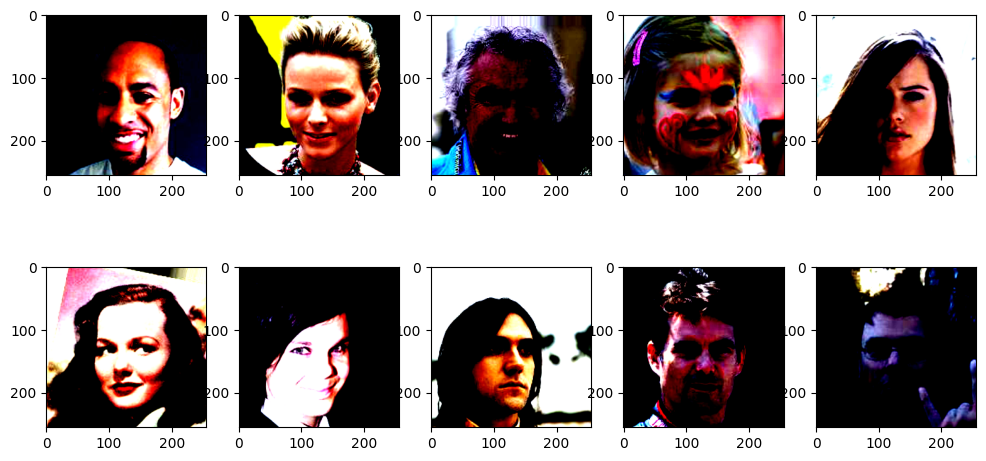

In [5]:
import matplotlib.pyplot as plt
import numpy as np

images_cnt = 10
plt.figure(figsize=(12, 6))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), images_cnt)):
    img, target = dataset[img_idx]
    # attributes dict for a given image. Contains 40 attributes
    attributes = {k:v for k,v in zip(dataset.header, target['attributes'].detach().cpu().numpy())}
    plt.subplot(2,5,i+1)
    plt.imshow(img.detach().cpu().numpy().transpose(1,2,0))

# Этап 2. Обучение модели
В рамках данного задания предлагается реализовать и обучить StarGAN для генережки лиц с заданными аттрибутами
![](assets/stargan.png)

Вам на выбор предлагается реализовать [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) (**до 4 баллов**) или [StarGANv2](https://arxiv.org/abs/1912.01865) (**до 7 баллов**)

In [46]:
from os.path import join as ospj

from checkpoint import CheckpointIO
from model import build_model

args.latent_dim = 16
args.hidden_dim = 512
args.style_dim = 64
args.img_size = 256

nets, _ = build_model(device=device, **args)

args.checkpoint_dir = "checkpoints"

chkpt = CheckpointIO(ospj(args.checkpoint_dir, '{:06d}_nets.ckpt'), **nets)
chkpt.load(step=73000)

Loading checkpoint from checkpoints/003000_nets.ckpt...


# Evaluation

In [9]:
lpips = LPIPS()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/jovyan/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /home/jovyan/.cache/torch/hub/checkpoints/alex.pth


  0%|          | 0.00/5.87k [00:00<?, ?B/s]

In [49]:
from tqdm.auto import trange
import numpy as np

test_iters = 100
values = []
y_targets, styles = [], []
with torch.inference_mode():
    for i in trange(test_iters):
        # fetch images and labels
        x_real = next(iter(dataloader)).x[0]
        x_ref = next(iter(dataloader)).x[0]
        x_ref2 = next(iter(dataloader)).x[0]
        batch_size = x_real.shape[0]
        y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size)) # целевой домен
        y_org = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size)) # ваш домен

        x_real, x_ref, x_ref2 = [x.to(device).float() for x in [x_real, x_ref, x_ref2]]
        y_trg, y_org = [x.to(device).long() for x in [y_trg, y_org]]

        style = nets.style_encoder(x_ref, y_trg)
        x_fake = nets.generator(x_real, style)

        values.append(lpips(x_fake.cpu(), x_real.cpu()).squeeze().item() / batch_size)
        y_targets += y_trg.tolist()
        styles += [tns.cpu().numpy() for tns in style]

assert(np.mean(values) < 1.3)

  0%|          | 0/100 [00:00<?, ?it/s]

In [50]:
np.mean(values)

0.4203292253613472

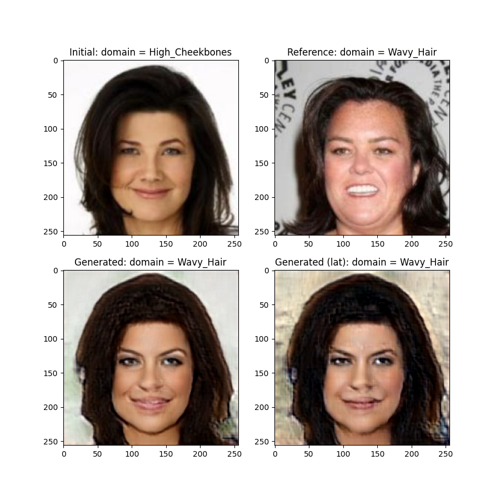

In [51]:
from PIL import Image

Image.open("samples/3000.png").convert("RGB").resize((500, 500))

Видно, что модель способна сохранять исходное качество, но не до конца обучилась добавлять признаки нового домена (выше она добавила скорее наиболее частый - яркую косметику), волосы же стали более волнистыми только в левой части картинки.

# Этап 3(\*). Дополнительный анализ

* Анализ латентного пространства и визуально качественный результат - **2 балла**
* Текстовое ревью решения и предложения возможных улучшений - **1 балл**

<Figure size 648x648 with 0 Axes>

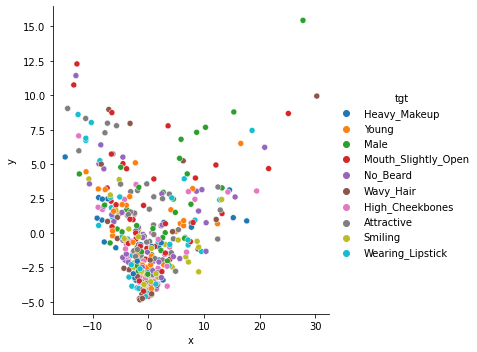

In [54]:
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

plt.gcf().set_size_inches(9, 9)

y_targets = np.array(y_targets)
styles = np.array(styles)

styles_2d = PCA(n_components=2).fit_transform(styles)
assert styles_2d.shape == (len(y_targets), 2)

targets = [dataset.header[idx] for idx in y_targets] 

data = pd.DataFrame(data={"x": styles_2d[:, 0], "y": styles_2d[:, 1], "tgt": targets})
sns.relplot(data=data, x="x", y="y", hue="tgt");

Перевод эмбеддингов стиля в 2D показывает, что многие находятся достаточно близко. Заметно выбивается признак Male, поскольку другие часто относятся к женской внешности.

Авторы [статьи](https://arxiv.org/abs/1912.01865) работают над важной для GANов задачей условной генерации. Чтобы полноправно конкурировать с современным SOTA диффузионками, корректная поддержка условия необходима. В качестве условий используются доменные признаки (черты лица), среди которых я оставил 10 самых популярных, чтобы модель обучалась быстрее (на более сложном пространстве со многими, в том числе малыми, доменами обучение занимало бы значительно большее время). Решение включает в себя следующие части

- `Generator (36M params)` отвечает за генерацию нового изображения на основе стиля и старого варианта. Он не генерирует картинку с нуля, вместо этого только меняя в ней определённые признаки.
- `MappingNetwork (9M params)` позволяет добавить случайности и объединить domain-specific информацию с этой случайностью, что позволяет увеличить разнообразие генерации (очень полезно для GAN-ов). Так авторы по сути используют положительные стороны `VAE` и `Diffusion Models`.
- `StyleEncoder (21M params)` принимает на вход картинку и таргет-домен, осуществляет их объединение и на выходе возвращает эмбеддинг таргета при дополнительном знании о картинке. Это гораздо лучше использования слоя эмбеддингов, поскольку поддерживает разнообразие и позволяет обучить больше параметров (при условии большого набора данных это плюс).
- `Discriminator (20M params)` играет вспомогательную роль во время обучения (как обычно). Учитывает домены, что логично, иначе он терял бы часть важной информации.

Суммарно используется около `85M` параметров, что достаточно много.

В своей реализации я использовал код авторов для обучения и сохранения чекпоинтов, чтобы из-за моих багов в этих разделах не потерять всё оставшееся время на дебаге. Также я сразу использовал значения гиперпараметров из статьи, что можно видеть в `main.py`.

Поскольку я достаточно мало занимался GAN-ами, для меня такой подход в генерации (например, `MappingNetwork`) оказался новым и очень многообещающим. Авторы используют много технических идей для `loss`-ов и решение в целом очень хорошо проработано. Я могу предложить следующие направления для исследования

1. Для подсчёта эмбеддинга стиля используются один таргет-домен. Это позволяет сделать процесс обучения универсальным, но всё же на каждый конкретной итерации модель получает только часть информации о доменах картинки. Чтобы исправить это и поддержать возможность multi-domain семплирования, можно усреднять эмбеддинги нескольких доменов (лучше случайного просемплированного количества из общего числа положительных). Я не нашёл в статье этой идеи, но мог её пропустить, если она где-то промелькнула.
2. Можно пойти дальше в схожести с `VAE` и `DDPM` и использовать в качестве семпла `z` из нормального распределения не вектор, а полноценную картинку (правильно организовав для этого архитектуру и, например, пошерив некоторые веса из разных частей модели). Однако стоит отметить, что это замедлит скорость работы.
